## Bayesian Inference

This code is based on Bayesian statistics to carry out Stock return analysis.

- Bayesian analysis for stock return data
- Build models for different distributions of data
- Compare models

In this code, I used the Baysesian approach for analysis of stock return data.
In particular, I modelled the data as a normal distribution and estimated distribution parameters using Markov chain Monte Carlo technique (MCMC).

The MCMC sampler draws parameter values from the prior distribution and computes the likelihood that the observed data came from a distribution with these parameter values.


In [43]:
#required imports

import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy
import scipy.stats as stats
import statsmodels.api as sm
import theano.tensor as tt
import seaborn as sns
from datetime import datetime

## Get the data:
pd.core.common.is_list_like = pd.api.types.is_list_like # resolves datareader error
from pandas_datareader import data


from IPython.display import Image
from datetime import datetime
%matplotlib inline

plt.style.use('seaborn-darkgrid')

print('done')

done


### Returns
Extract historical data for Apple (AAPL) [2015 - 2016], calculate daily returns, and estimate the mean daily return. Remove NaN from dataset. Plot histogram of daily returns.
 

In [3]:
import quandl
quandl.ApiConfig.api_key = '4XWVLg3qR7xBfGT4PF3i'

data= quandl.get('WIKI/AAPL', start_date='2015-1-1', end_date='2016-12-31')
print(type(data))

data.to_csv('data.csv')

returns=data['Adj. Close'].pct_change()

returns = returns.dropna()*100

<class 'pandas.core.frame.DataFrame'>


#### Question 1

1. Plot the returns and draw a histogram to see the distribution


In [4]:
data.head()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2015-01-02,111.39,111.44,107.350,109.33,53204626.0,0.0,1.0,105.820966,105.868466,101.982949,103.863957,53204626.0
2015-01-05,108.29,108.65,105.410,106.25,64285491.0,0.0,1.0,102.875953,103.217954,100.139941,100.937944,64285491.0
2015-01-06,106.54,107.43,104.630,106.26,65797116.0,0.0,1.0,101.213446,102.058949,99.398938,100.947444,65797116.0
2015-01-07,107.20,108.20,106.695,107.75,40105934.0,0.0,1.0,101.840448,102.790453,101.360696,102.362951,40105934.0
2015-01-08,109.23,112.15,108.700,111.89,59364547.0,0.0,1.0,103.768957,106.542969,103.265455,106.295968,59364547.0


In [13]:

returns.describe()

count    503.000000
mean       0.031662
std        1.579874
min       -6.570657
25%       -0.716921
50%        0.040068
75%        0.850964
max        6.496328
Name: Adj. Close, dtype: float64

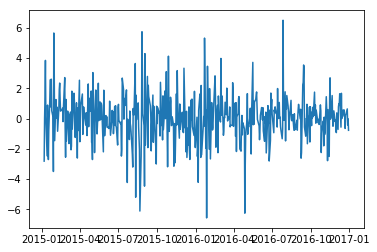

In [8]:

plt.plot(returns)

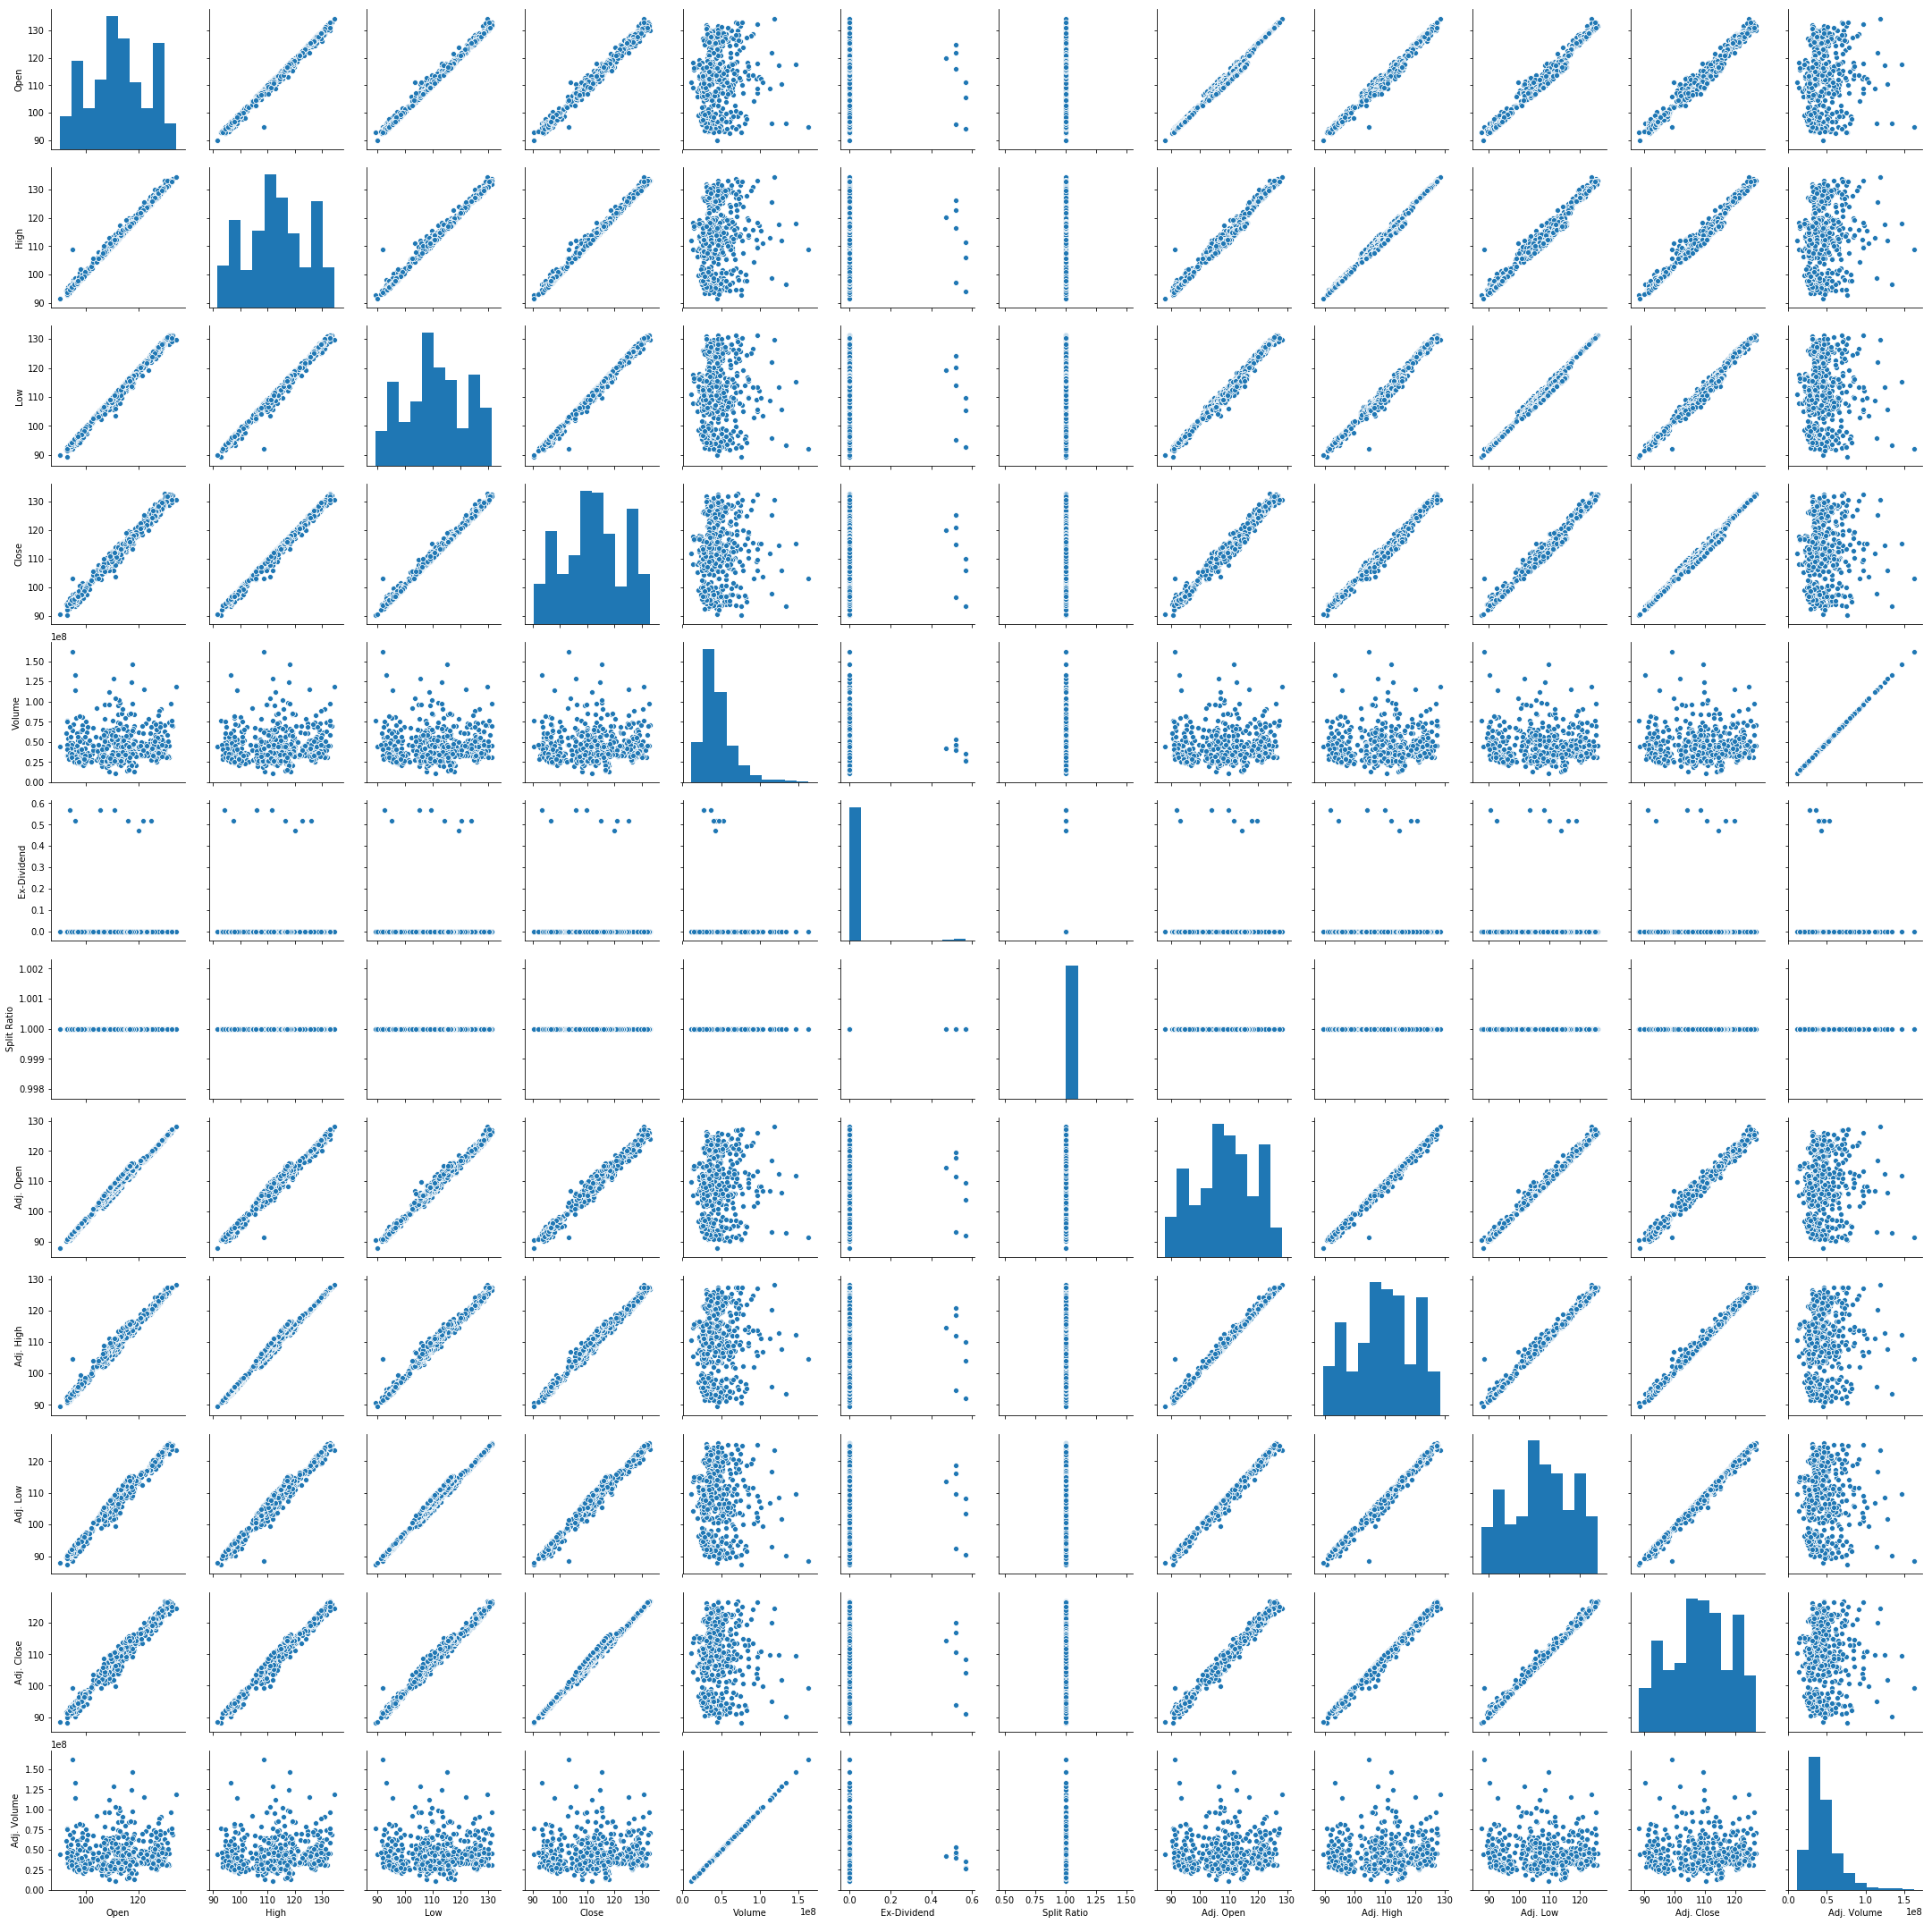

In [11]:
sns.pairplot(data)

(array([  3.,   4.,  14.,  55., 162., 179.,  61.,  18.,   3.,   4.]),
 array([-6.57065707, -5.26395859, -3.95726011, -2.65056163, -1.34386315,
        -0.03716468,  1.2695338 ,  2.57623228,  3.88293076,  5.18962923,
         6.49632771]),
 <a list of 10 Patch objects>)

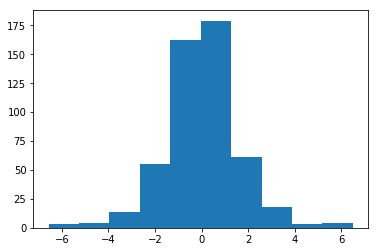

In [15]:

plt.hist(returns)

In the cell below, the model for daily return simulations is shown. Since the daily returns histogram shows bell-shaped distribution, the normal distribution is used for likelihood computation.

This model uses un-informative priors - Uniform distribution for both parameters of the notmal distribution ("mu" and 'sigma").

In [38]:
with pm.Model() as model_n:
    #Prior
    mu = pm.Uniform("mu", lower=-10, upper=10, testval=0)
    sigma = pm.Uniform("sigma", lower=0, upper=6, testval=0.0001)
    
    #Likelihood
    likelihood = pm.Normal("likelihood", mu=mu, sd=sigma, observed = returns.values)
    
    #Posterior
    start = pm.find_MAP()
    step  = pm.Metropolis()
    trace = pm.sample(10000, step=step, start=start, progressbar=True)
    burned_trace = trace[3000::2]

C:\Users\34pt\AppData\Local\Continuum\anaconda3\lib\site-packages\pymc3\tuning\starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -969.97, ||grad|| = 483.7: 100%|████████████████████████████████████████████████| 37/37 [00:00<00:00, 41.58it/s]
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [mu]
Sampling 4 chains: 100%|██████████████████████████████████████████████████████| 42000/42000 [09:30<00:00, 73.66draws/s]
The number of effective samples is smaller than 10% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000021799F27518>,
      dtype=object)

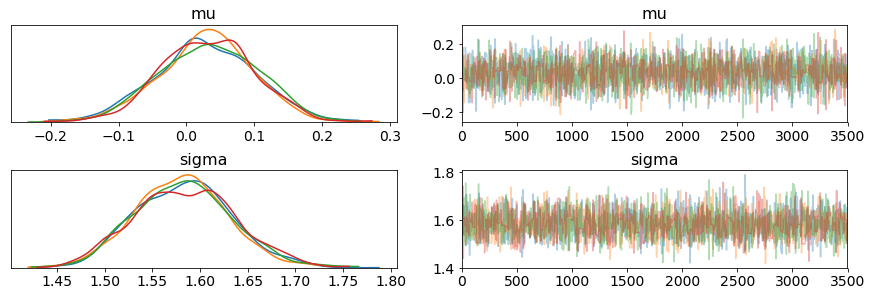

In [39]:
pm.traceplot(burned_trace)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002179AB90BA8>,
      dtype=object)

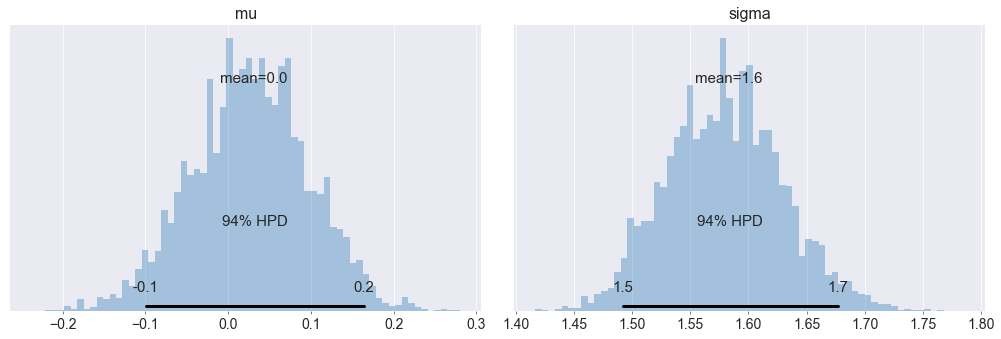

In [45]:
pm.plot_posterior(burned_trace,kind='hist')

#### Question 2

Improve the model for daily returns given above.
Choose different prior distributions for parameters of the likelihood distribution - Mean $\mu$ and Standard Deviation $\sigma$.

To tune the model, try several different distributions with various spread/dispersion values (for example, Uniform, Normal, HalfNormal) for priors, and different numbers of samples.
By inspecting posterior distribution of parameters, pick the value that produces the smoothest, most convergent chains. 

Present posterior distribution graphically. 

## Trial 1 - using HalfNormal distribution for priors

In [46]:
# trial 1

# YOUR CODE HERE
with pm.Model() as model_n:
    #Prior
    mu = pm.HalfNormal("mu", sd=0.07)# from previous model sd was calculated (0.167-(-0.108))/4
    sigma = pm.HalfNormal("sigma", sd=0.75)
    
    #Likelihood
    likelihood = pm.Normal("likelihood", mu=mu, sd=sigma, observed = returns.values)
    
    #Posterior
    start = pm.find_MAP()
    step  = pm.Metropolis()
    trace1 = pm.sample(10000, step=step, start=start, progressbar=True)
    burned_trace1 = trace1[3000::2]

C:\Users\34pt\AppData\Local\Continuum\anaconda3\lib\site-packages\pymc3\tuning\starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -943.13, ||grad|| = 8.5197: 100%|███████████████████████████████████████████████| 21/21 [00:00<00:00, 42.64it/s]
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [mu]
Sampling 4 chains: 100%|██████████████████████████████████████████████████████| 42000/42000 [09:24<00:00, 74.34draws/s]
The number of effective samples is smaller than 10% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002179B84E400>,
      dtype=object)

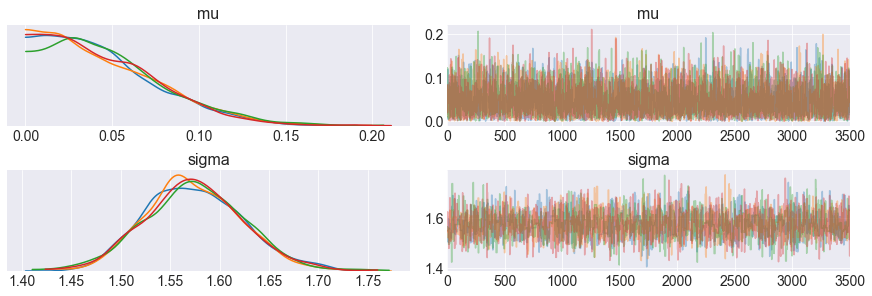

In [47]:
# SHOW TRACE PLOT
pm.traceplot(burned_trace1)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002179B56ADD8>,
      dtype=object)

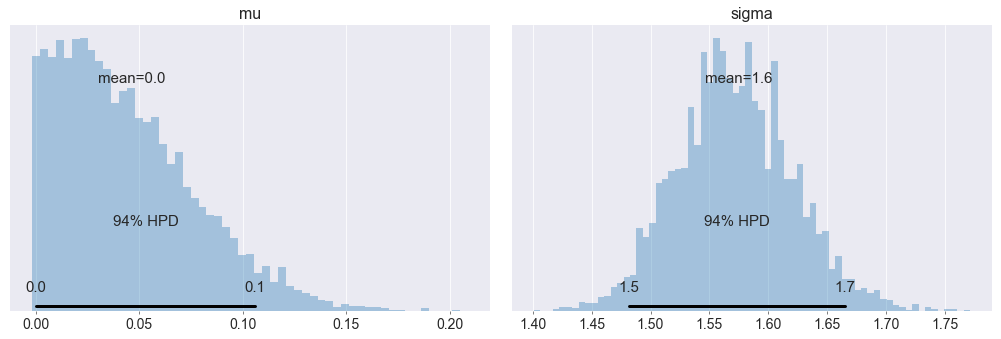

In [48]:
# PLOT POSTERIOR DISTRIBUTION
pm.plot_posterior(burned_trace1,kind='hist')

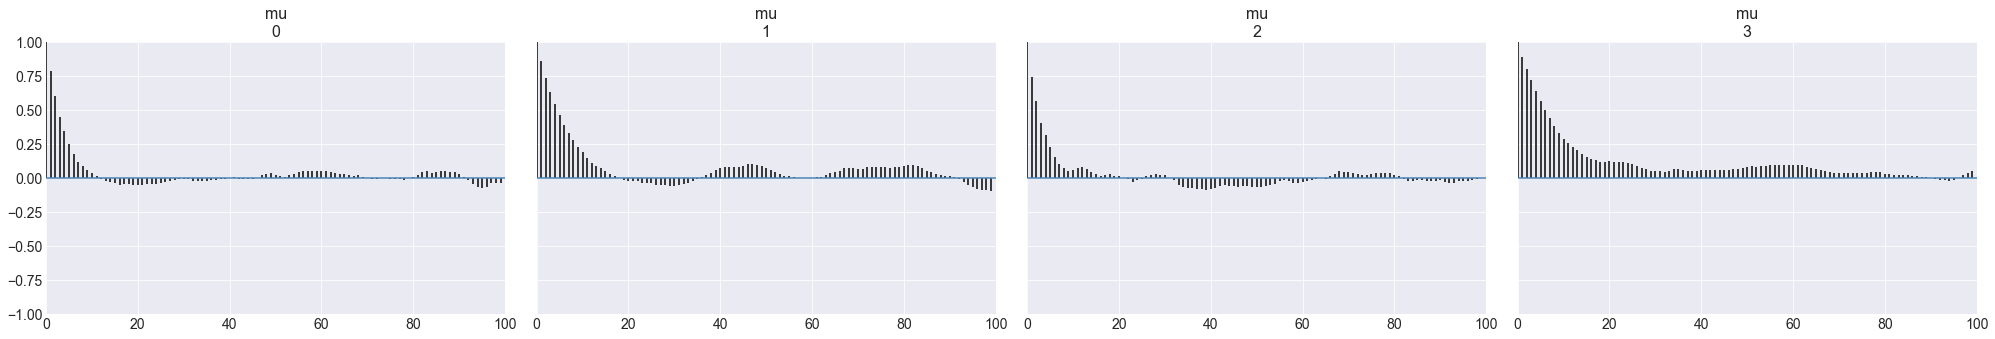

In [49]:
_ = pm.autocorrplot(trace[:2000], var_names=['mu'])


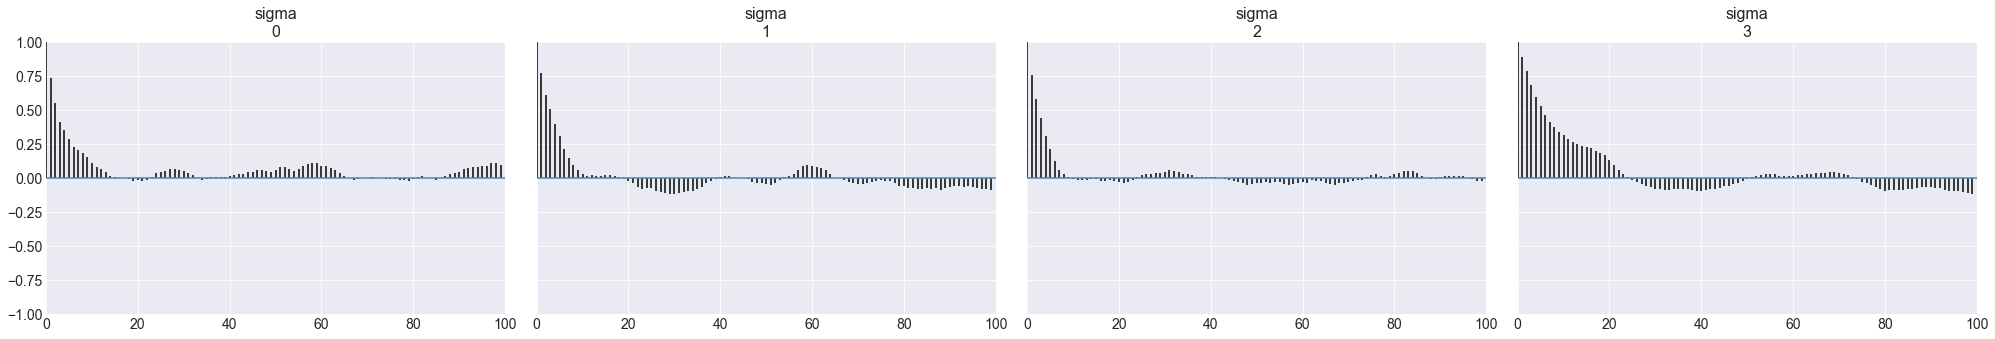

In [50]:
_ = pm.autocorrplot(trace[:2000], var_names=['sigma'])

## Trial 2 - using Normal distribution for priors

In [51]:
# Trial 2
# YOUR CODE HERE
with pm.Model() as model_n:
    #Prior
    mu = pm.Normal("mu", mu=0.03, sd=0.07)
    sigma = pm.Normal("sigma", mu=1.57, sd=0.75)
    
    #Likelihood
    likelihood = pm.Normal("likelihood", mu=mu, sd=sigma, observed = returns.values)
    
    #Posterior
    start = pm.find_MAP()
    step  = pm.Metropolis()
    trace2 = pm.sample(10000, step=step, start=start, progressbar=True)
    burned_trace2 = trace2[3000::2]

C:\Users\34pt\AppData\Local\Continuum\anaconda3\lib\site-packages\pymc3\tuning\starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -942.18, ||grad|| = 3.4149: 100%|█████████████████████████████████████████████████| 6/6 [00:00<00:00, 45.24it/s]
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [mu]
Sampling 4 chains: 100%|██████████████████████████████████████████████████████| 42000/42000 [09:43<00:00, 23.65draws/s]
The number of effective samples is smaller than 10% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002179F3E84E0>,
      dtype=object)

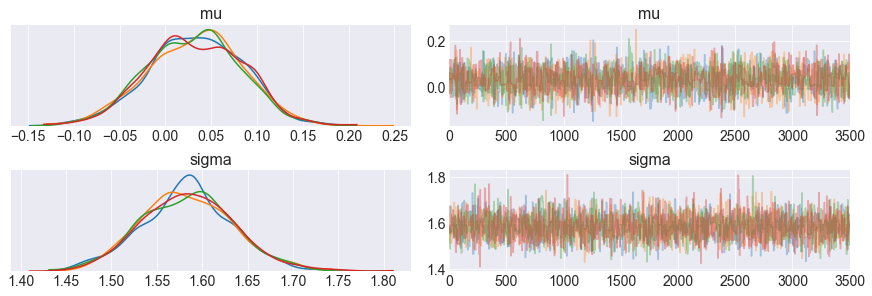

In [52]:
# SHOW TRACE PLOT
pm.traceplot(burned_trace2)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002179F57C518>,
      dtype=object)

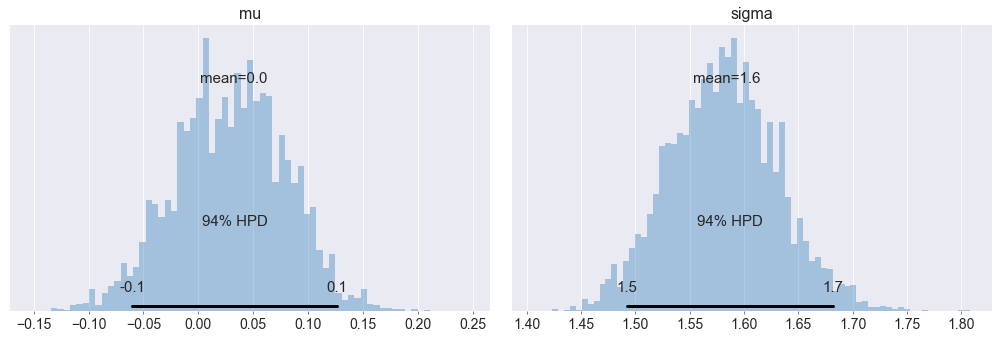

In [53]:
# PLOT POSTERIOR DISTRIBUTION
pm.plot_posterior(burned_trace2, kind='hist')

## Trial 3 - using Normal priors and 2000 samples instead of 10000

In [54]:
# Trial 3
# YOUR CODE HERE
with pm.Model() as model_n:
    #Prior
    mu = pm.Normal("mu", mu=0.03, sd=0.07)
    sigma = pm.Normal("sigma", mu=1.57, sd=0.75)
    
    #Likelihood
    likelihood = pm.Normal("likelihood", mu=mu, sd=sigma, observed = returns.values)
    
    #Posterior
    start = pm.find_MAP()
    step  = pm.Metropolis()
    trace3 = pm.sample(2000, step=step, start=start, progressbar=True)
    burned_trace3 = trace3[300::2]

C:\Users\34pt\AppData\Local\Continuum\anaconda3\lib\site-packages\pymc3\tuning\starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -942.18, ||grad|| = 3.4149: 100%|█████████████████████████████████████████████████| 6/6 [00:00<00:00, 49.88it/s]
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [mu]
Sampling 4 chains: 100%|██████████████████████████████████████████████████████| 10000/10000 [02:26<00:00, 68.35draws/s]
The number of effective samples is smaller than 10% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000217964CD198>,
      dtype=object)

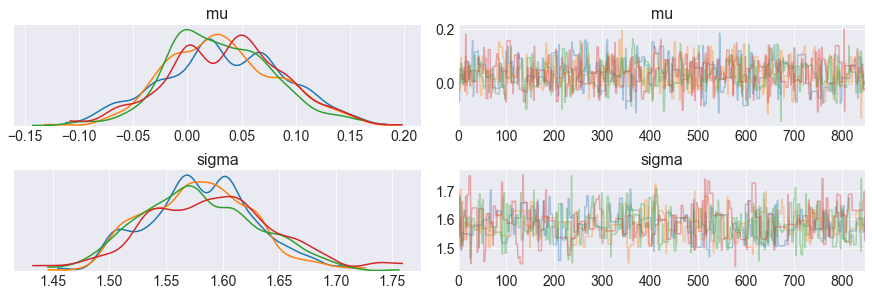

In [55]:
# SHOW TRACE PLOT
pm.traceplot(burned_trace3)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002179AB1EDA0>,
      dtype=object)

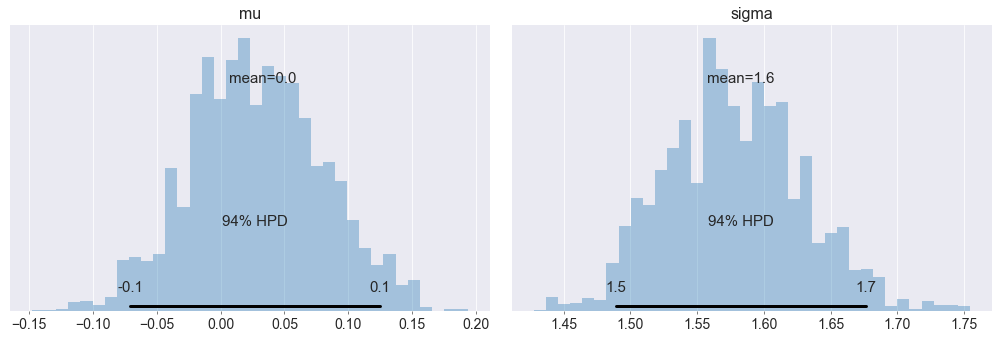

In [56]:
# PLOT POSTERIOR DISTRIBUTION
pm.plot_posterior(burned_trace3, kind='hist')

## Trial 4 - using Normal priors and 20000 samples instead of 10000

In [57]:
# Trial 4
# YOUR CODE HERE
with pm.Model() as model_n:
    #Prior
    mu = pm.Normal("mu", mu=0.03, sd=0.07)
    sigma = pm.Normal("sigma", mu=1.57, sd=0.75)
    
    #Likelihood
    likelihood = pm.Normal("likelihood", mu=mu, sd=sigma, observed = returns.values)
    
    #Posterior
    start = pm.find_MAP()
    step  = pm.Metropolis()
    trace4 = pm.sample(20000, step=step, start=start, progressbar=True)
    

C:\Users\34pt\AppData\Local\Continuum\anaconda3\lib\site-packages\pymc3\tuning\starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -942.18, ||grad|| = 3.4149: 100%|█████████████████████████████████████████████████| 6/6 [00:00<00:00, 54.43it/s]
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [mu]
Sampling 4 chains: 100%|██████████████████████████████████████████████████████| 82000/82000 [20:25<00:00, 66.91draws/s]
The number of effective samples is smaller than 10% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002179E8DAC18>,
      dtype=object)

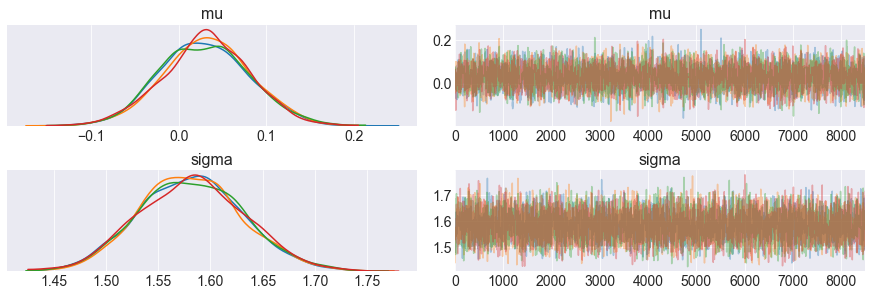

In [59]:
# SHOW TRACE PLOT
burned_trace4 = trace4[3000::2]
pm.traceplot(burned_trace4)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002179E85BB00>,
      dtype=object)

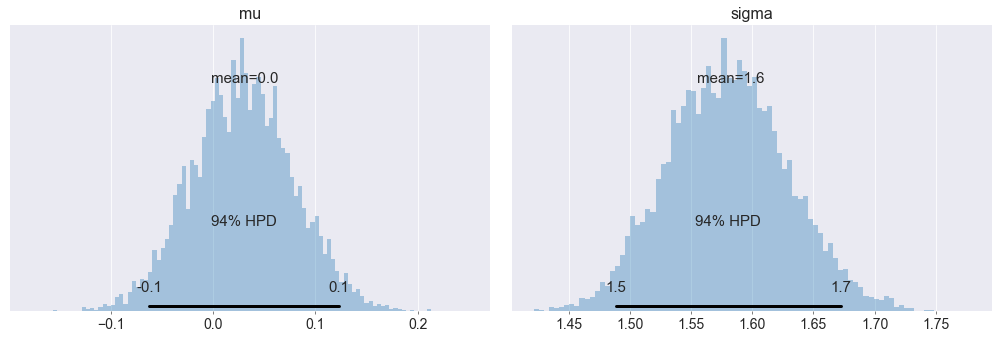

In [60]:
# PLOT POSTERIOR DISTRIBUTION
pm.plot_posterior(burned_trace4, kind='hist')

## Trial 5 - using Normal priors with different mu and sd values

In [61]:
# Trial 5
# YOUR CODE HERE
with pm.Model() as model_n:
    #Prior
    mu = pm.Normal("mu", mu=0.0, sd=0.1)
    sigma = pm.Normal("sigma", mu=1, sd=1)
    
    #Likelihood
    likelihood = pm.Normal("likelihood", mu=mu, sd=sigma, observed = returns.values)
    
    #Posterior
    start = pm.find_MAP()
    step  = pm.Metropolis()
    trace5 = pm.sample(10000, step=step, start=start, progressbar=True)
    burned_trace5 = trace5[3000::2]

C:\Users\34pt\AppData\Local\Continuum\anaconda3\lib\site-packages\pymc3\tuning\starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -1,088.5, ||grad|| = 750.67: 100%|██████████████████████████████████████████████| 10/10 [00:00<00:00, 50.14it/s]
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [mu]
Sampling 4 chains: 100%|██████████████████████████████████████████████████████| 42000/42000 [10:23<00:00, 67.40draws/s]
The number of effective samples is smaller than 10% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000217A19F6710>,
      dtype=object)

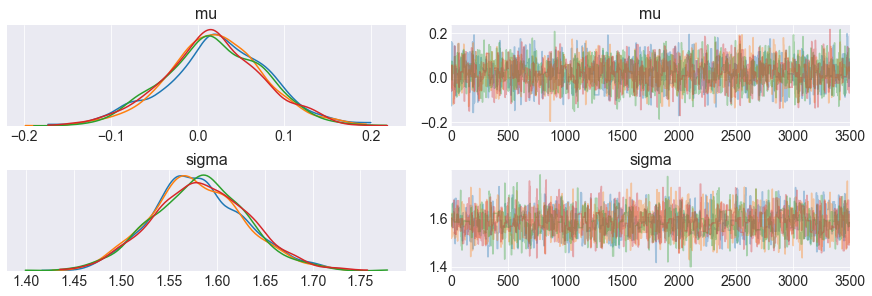

In [62]:
# SHOW TRACE PLOT
burned_trace5 = trace5[3000::2]
pm.traceplot(burned_trace5)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002179A043198>,
      dtype=object)

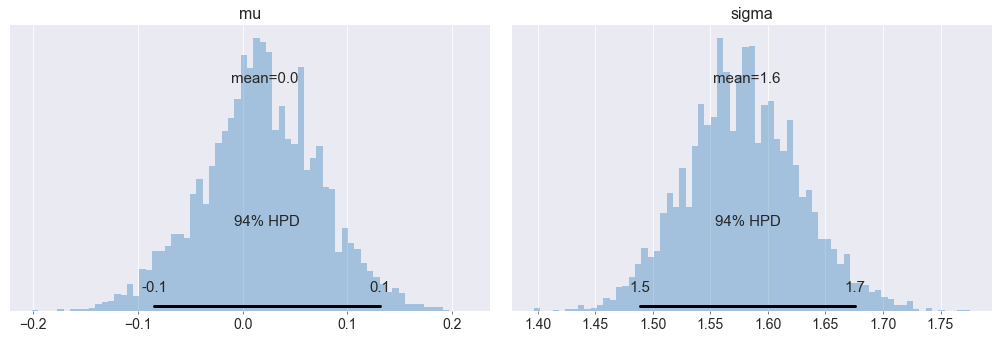

In [63]:
# PLOT POSTERIOR DISTRIBUTION
pm.plot_posterior(burned_trace5, kind='hist')

__Answer to Question 2__

By comapring the different posterior graphs, it seems that the Normal distribution for parameters of the likelihood distribution - Mean  𝜇  and Standard Deviation  𝜎  and 20,000 samples (Trial 4) gives the smothest and and most convergent chains. 


#### Question 3

As a validation check of model performance, predict the distribution of daily returns from the obtained posterior distributions. To generate the data, use the pymc3 function for sampling posterior distribution with an appropriately chosen number of samples from the trace.

Present results of predicted distribution graphically as a histogram.

In [64]:
# Sample posterior to obtain the distribution of daily returns
ppc = pm.sample_posterior_predictive(burned_trace4, samples=500, model=model_n)

100%|██████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 1330.08it/s]


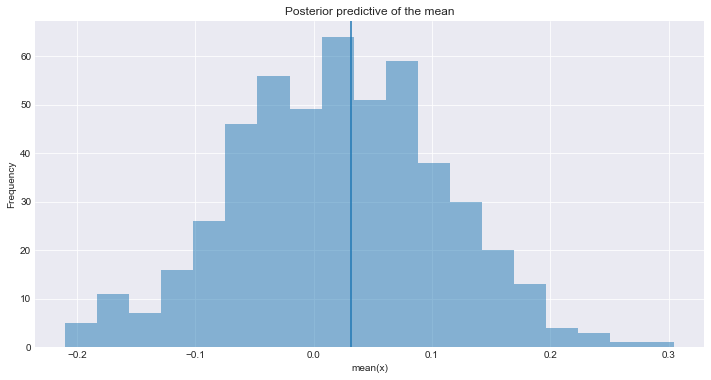

In [66]:
# Plot obtained distribution of daily return
_, ax = plt.subplots(figsize=(12, 6))
ax.hist([likelihood.mean() for likelihood in ppc['likelihood']], bins=19, alpha=0.5)
ax.axvline(returns.mean())
ax.set(title='Posterior predictive of the mean', xlabel='mean(x)', ylabel='Frequency');

#### Question 4

(a) Identify the parameter of interest in the prediction model. What would be the best prior distribution to produce these parameters? 

(b) What is the HDI in the posteriors for the parameters you named in 4a? What number of samples was used to build this model? 

(c) Does the data generated when predicting daily returns from posterior distribution deviate significantly from the true distribution?

__Answer to Question 4__

a) The paramter of interest are mu and sigma for the normal distribution of liklihood. 
All priors ( uniform, halfnormal and normal) gave the same mean and 2xstd for the mu (0, 0.1) and for the sigma (1.6, 0.1) but the result for the normal prior were smoother. 

b)94% for mu (-0.1 to 0.1) and for Sigma (1.5 to 1.7) . The number of samples ranges form 2000 to 20,000 and all of them gave the same HDI. 


c)No, the predicted parameter from posterior distribution are very close to the parameters of the true dixtribution. 

In [81]:
pm.summary(burned_trace4)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mu,0.030851,0.049713,0.000668,-0.062714,0.131298,6242.100414,1.000561
sigma,1.582147,0.049406,0.000523,1.487360,1.678398,7150.558821,1.000016
